# 导入必要的库

我们需要导入一个叫 [captcha](https://github.com/lepture/captcha/) 的库来生成验证码。

我们生成验证码的字符由数字和大写字母组成。

In [1]:
from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
import numpy as np
import random

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import string
characters = string.digits + string.ascii_uppercase
print(characters)

width, height, n_len, n_class = 170, 80, 4, len(characters)

0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ


# 定义数据生成器

In [8]:
from keras.utils.np_utils import to_categorical

def gen(batch_size=32):
    X = np.zeros((height, width, 3), dtype=np.uint8)
    y = [np.zeros((n_class), dtype=np.uint8) for i in range(n_len)]
    generator = ImageCaptcha(width=width, height=height)
    while True:
        random_str = ''.join([random.choice(characters) for j in range(4)])
        X = generator.generate_image(random_str)
        for j, ch in enumerate(random_str):
            y[j][:] = 0
            y[j][characters.find(ch)] = 1
        yield X, y

# 测试生成器

In [19]:
print np.argmax(np.array(y), axis=1)
print np.argmax(np.array([[1, 2, 3], [4, 5, 6]]), axis=1)

[21  0  5  6]
[2 2]


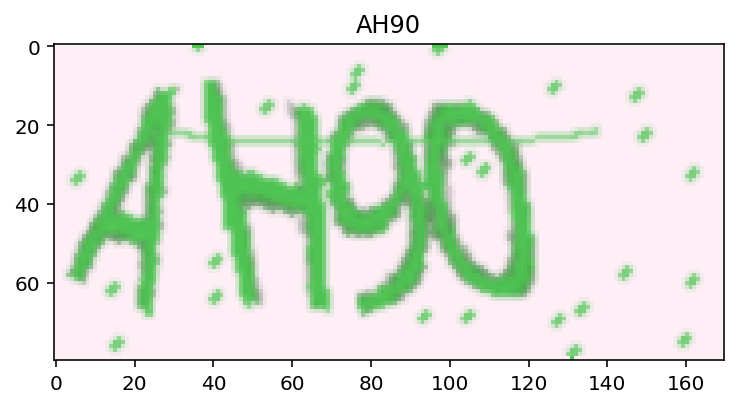

In [21]:
def decode(y):
    y = np.argmax(np.array(y), axis=1)
    return ''.join([characters[x] for x in y])

X, y = next(gen())
plt.imshow(X)
plt.title(decode(y))

# 定义网络结构

In [22]:
from keras.models import *
from keras.layers import *

input_tensor = Input((height, width, 3))
x = input_tensor
#for i in range(4):
    #x = Convolution2D(32*2**i, 3, 3, activation='relu')(x)
    #x = Convolution2D(32*2**i, 3, 3, activation='relu')(x)
    #x = MaxPooling2D((2, 2))(x)

x = Conv2D(32, (3, 3), activation='relu')(x)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu')(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu')(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(256, (3, 3), activation='relu')(x)
x = Conv2D(256, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = [Dense(n_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(4)]
model = Model(inputs=input_tensor, outputs=x)

model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

# 网络结构可视化

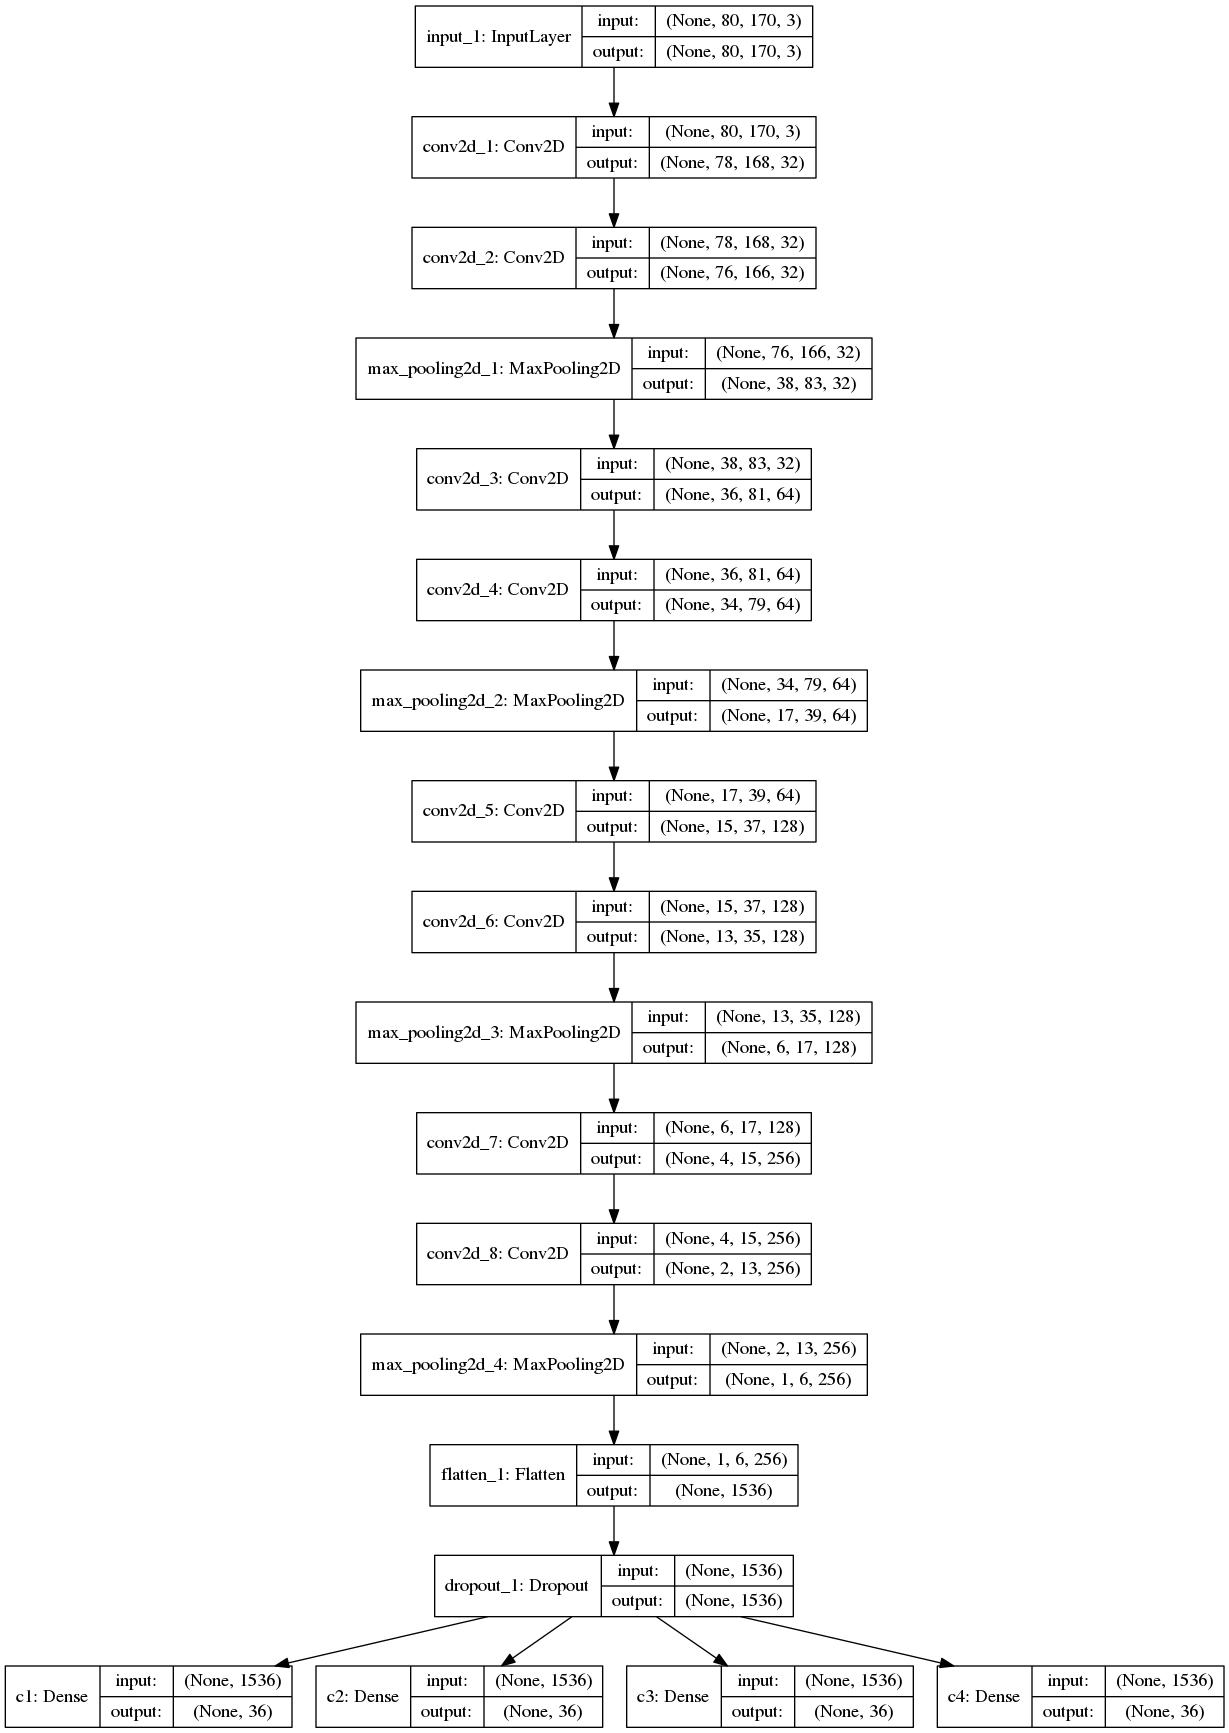

In [23]:
from keras.utils.vis_utils import plot_model
from IPython.display import Image

plot_model(model, to_file="model.png", show_shapes=True)
Image('model.png')

# 训练模型

In [24]:
model.fit_generator(gen(), steps_per_epoch=10, epochs=5,
                    validation_data=gen(), validation_steps=20)

Epoch 1/5


AttributeError: 'Image' object has no attribute 'shape'

# 测试模型

(-0.5, 169.5, 79.5, -0.5)

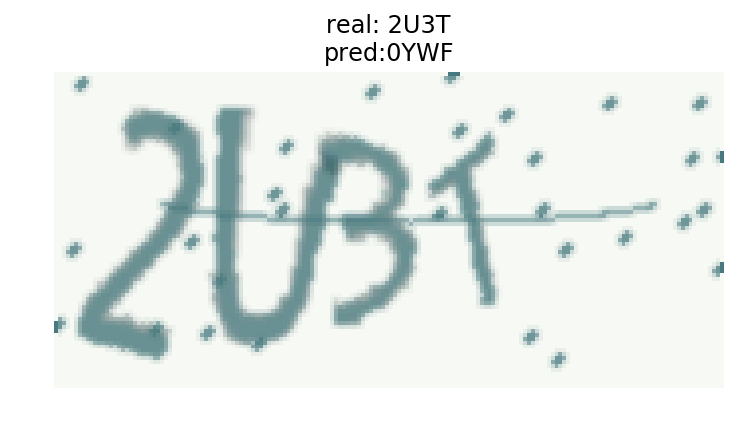

In [7]:
X, y = next(gen(1))
y_pred = model.predict(X)
plt.title('real: %s\npred:%s'%(decode(y), decode(y_pred)))
plt.imshow(X[0], cmap='gray')
plt.axis('off')

# 计算模型总体准确率

In [8]:
from tqdm import tqdm
def evaluate(model, batch_num=20):
    batch_acc = 0
    generator = gen()
    for i in tqdm(range(batch_num)):
        X, y = generator.next()
        y_pred = model.predict(X)
        batch_acc += np.mean(map(np.array_equal, np.argmax(y, axis=2).T, np.argmax(y_pred, axis=2).T))
    return batch_acc / batch_num

evaluate(model)

100%|██████████| 20/20 [01:01<00:00,  2.87s/it]


0.0

# 保存模型

In [9]:
model.save('cnn.h5')